Device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3601160991.py:76: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(


Classes: ['Blight', 'Healthy', 'Spot']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

/tmp/ipython-input-3601160991.py:167: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3601160991.py:183: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1/50] Train Acc: 0.8815 | Val Acc: 0.9615
✅ Best model saved
[Epoch 2/50] Train Acc: 0.9847 | Val Acc: 0.9744
✅ Best model saved
[Epoch 3/50] Train Acc: 0.9841 | Val Acc: 0.9615
[Epoch 4/50] Train Acc: 0.9931 | Val Acc: 0.9487
[Epoch 5/50] Train Acc: 0.9937 | Val Acc: 0.9744
[Epoch 6/50] Train Acc: 0.9979 | Val Acc: 0.9744
[Epoch 7/50] Train Acc: 0.9984 | Val Acc: 0.9744
[Epoch 8/50] Train Acc: 0.9968 | Val Acc: 0.8846
[Epoch 9/50] Train Acc: 0.9942 | Val Acc: 0.9744
[Epoch 10/50] Train Acc: 0.9979 | Val Acc: 0.9744
[Epoch 11/50] Train Acc: 0.9984 | Val Acc: 0.9615
[Epoch 12/50] Train Acc: 0.9974 | Val Acc: 0.9744
[Epoch 13/50] Train Acc: 0.9921 | Val Acc: 0.9615
[Epoch 14/50] Train Acc: 0.9984 | Val Acc: 0.9615
[Epoch 15/50] Train Acc: 0.9974 | Val Acc: 0.9744
[Epoch 16/50] Train Acc: 0.9958 | Val Acc: 0.9487
[Epoch 17/50] Train Acc: 0.9968 | Val Acc: 0.9615
[Epoch 18/50] Train Acc: 0.9984 | Val Acc: 0.9615
[Epoch 19/50] Train Acc: 0.9937 | Val Acc: 0.9744
[Epoch 20/50] Train A

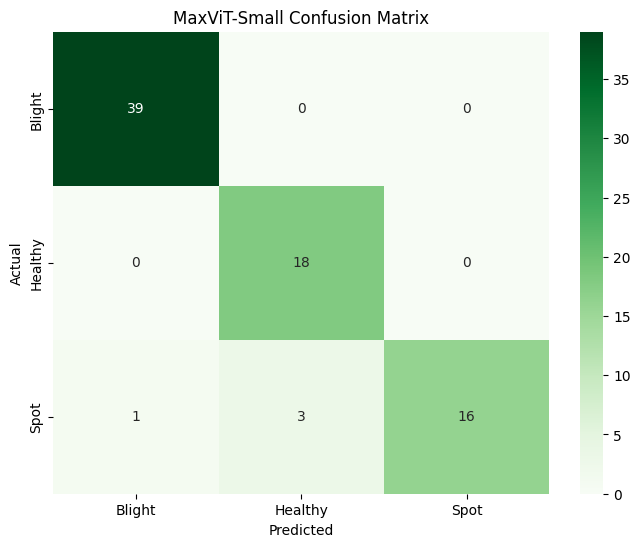

✅ MaxViT ماډل په Google Drive کې ذخیره شو


In [1]:
# ======================================================
# MaxViT-Small Training
# ImageNet Pretrained | Small Dataset (~2000 images)
# Batch=16 | AMP Enabled | No Gradient Accumulation
# ======================================================

# ----------------------
# Imports
# ----------------------
import os
import torch, timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score
)

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler

# ----------------------
# Device
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------
# Mount Google Drive
# ----------------------
from google.colab import drive
drive.mount('/content/drive')

# ----------------------
# Paths
# ----------------------
DATA_DIR = "/content/drive/MyDrive/my Collected Dataset/Kandahar Field data/Actual Field_dataset With Original Background"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# ----------------------
# Model Config
# ----------------------
MODEL_NAME = "maxvit_small_tf_224"
IMG_SIZE = 224

# ----------------------
# Hyperparameters (Scientific Setup)
# ----------------------
BATCH = 16
NUM_EPOCHS = 50
LR = 1e-4                 # MaxViT-friendly LR
WEIGHT_DECAY = 1e-4

MODEL_SAVE = f"/content/best_{MODEL_NAME}_imagenet.pth"

# ----------------------
# Albumentations (Strong Augmentation)
# ----------------------
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.4),
    A.CoarseDropout(
        max_holes=2,
        max_height=32,
        max_width=32,
        p=0.3
    ),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

# ----------------------
# Dataset Wrapper
# ----------------------
class AlbDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root)
        self.transform = transform
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

# ----------------------
# DataLoaders
# ----------------------
train_loader = DataLoader(
    AlbDataset(TRAIN_DIR, train_tfms),
    batch_size=BATCH,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    AlbDataset(VALID_DIR, val_tfms),
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    AlbDataset(TEST_DIR, val_tfms),
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

num_classes = len(train_loader.dataset.classes)
print("Classes:", train_loader.dataset.classes)

# ----------------------
# Model (MaxViT)
# ----------------------
model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.2        # regularization for small data
).to(device)

# ----------------------
# Loss & Optimizer
# ----------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scaler = GradScaler()

# ----------------------
# Training Loop
# ----------------------
best_val_acc = 0.0
train_acc_hist, val_acc_hist = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_acc_hist.append(val_acc)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE)
        print("✅ Best model saved")

print("Training finished | Best Val Acc:", best_val_acc)

# ----------------------
# Testing
# ----------------------
model.load_state_dict(torch.load(MODEL_SAVE))
model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=train_loader.dataset.classes
))

print("F1:", f1_score(all_labels, all_preds, average="macro"))
print("Recall:", recall_score(all_labels, all_preds, average="macro"))
print("Precision:", precision_score(all_labels, all_preds, average="macro"))

# ----------------------
# Confusion Matrix
# ----------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=train_loader.dataset.classes,
    yticklabels=train_loader.dataset.classes
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MaxViT-Small Confusion Matrix")
plt.show()

# ----------------------
# Save to Google Drive
# ----------------------
save_folder = "/content/drive/MyDrive/Corn_MaxViT_models"
os.makedirs(save_folder, exist_ok=True)

torch.save(model, f"{save_folder}/{MODEL_NAME}_full_model.pth")
torch.save(model.state_dict(), f"{save_folder}/{MODEL_NAME}_weights_only.pth")

print("✅ MaxViT ماډل په Google Drive کې ذخیره شو")
